# Topic modelling

In [3]:
# generally useful packages
import re
import pprint
import glob, os, requests
import pickle
import collections

# # for data management, visualization and math
# import pandas as pd
# import numpy as np
# #import networkx as nx
# import matplotlib.pyplot as plt
# import seaborn as sns
# import folium

# NLP packages, we work with German text so we load that
import nltk
import gensim
import spacy
nlp = spacy.load("de_core_news_sm")

# visualization for NLP
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# # for location detection
# from geotext import GeoText

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)


D:\anaconda\envs\data4good\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
D:\anaconda\envs\data4good\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
D:\anaconda\envs\data4good\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
D:\anaconda\envs\data4good\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
D:\anaconda\envs\data4good\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpackb(packed, **kwargs)
D:\anaconda\envs\data4good\lib\site-packages\msgpack_numpy.py:184: DeprecationWarning: encoding is deprecated, Use raw=False instead.
  return _unpack

# Building the corpus

Let's gather all the text files we have extracted in the interim folder

In [4]:
data_path = "../data/interim/pdf2text"

data_files = glob.glob(data_path + os.path.sep + "*.txt"); data_files

data_files = [item.replace(data_path + os.path.sep, "") for item in data_files]  # Strip the dir name and the path separator from begining

corpus = []

for txt_file in data_files:
    with open(data_path + os.path.sep + txt_file,  "r", encoding='utf-8') as f:
        corpus.append(f.readlines())

# Flattening the list:
corpus = [item for sublist in corpus for item in sublist]


Let's see what we have:

In [5]:
print(len(corpus), '\n', corpus[:10])


38770 
 ['Biodiversitätsdach auf dem Besucherzentrum der IGA Berlin 2017\n', 'Lebensraum Gründach\n', '\n', '\x0cInhalt\n', '\n', 'Dachbegrünung und Biodiversität\n', '\n', '2\n', '\n', 'Besucherzentrum IGA Berlin 2017\n']


## Cleaning up the corpus 

First, some cleaning to remove the email addresses:

In [6]:
# Remove Emails (GDPR)
for doc in corpus:
    doc = [re.sub('\S*@\S*\s?', '', sent) for sent in doc]

Let's tokenize the documents: and make everything lower case:

In [7]:
from nltk.tokenize import word_tokenize
clean_corpus = [word_tokenize(doc, language="german") for doc in corpus]

Now, we remove the stopwords, numbers and make everything lowercase:

In [8]:
nltk.download('stopwords')

# we have some English text in the German too so add those as well
from nltk.corpus import stopwords
stop_words = set(stopwords.words('german'))
stop_words = stop_words.union(set(stopwords.words('english')))

clean_corpus = [[word.lower() for word in doc if word.lower() not in stop_words and word.isalpha()] for doc in clean_corpus]
# remove empties
clean_corpus = [doc for doc in clean_corpus if len(doc) > 0]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
clean_corpus[:10]

[['biodiversitätsdach', 'besucherzentrum', 'iga', 'berlin'],
 ['lebensraum', 'gründach'],
 ['inhalt'],
 ['dachbegrünung', 'biodiversität'],
 ['besucherzentrum', 'iga', 'berlin'],
 ['biodiversitätsmodule'],
 ['pflanzenauswahl'],
 ['pflege', 'monitoring'],
 ['planung', 'biodiversitätsdächer'],
 ['kooperationspartner']]

# The LDA model and it's evaluation

We will learn the topics of our texts using Latend Dirichlet Analysis by the gensim package. First, we build a dictionary and get rid of very common or rare words.

In [9]:
from gensim.corpora.dictionary import Dictionary

dictionary = Dictionary(clean_corpus)

len(dictionary)

40831

In [10]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

len(dictionary)

2685

Next, we load the LDA model and using the above dictionary, build the bag of words representation of our corpus.

In [11]:
from gensim.models.ldamodel import LdaModel

d2b_corpus = [dictionary.doc2bow(doc) for doc in clean_corpus]
d2b_corpus[:10]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1)],
 [(6, 1)],
 [(7, 1), (8, 1)],
 [(0, 1), (1, 1), (3, 1)],
 [(9, 1)],
 [(10, 1)],
 [(11, 1), (12, 1)],
 [(13, 1)],
 [(14, 1)]]

Now, we train the LDA model to find 10 topics.

In [12]:
lda = LdaModel(corpus=d2b_corpus,
               id2word=dictionary,
               num_topics=10,
               update_every=1,
               chunksize=10000,
               passes=1)

lda.print_topics(10)

[(0,
  '0.015*"berlin" + 0.012*"dass" + 0.011*"wurde" + 0.009*"gebäudegrün" + 0.008*"fbb" + 0.007*"fassadenbegrünungssymposium" + 0.007*"bugg" + 0.006*"foto" + 0.006*"bauen" + 0.006*"gebäudebegrünung"'),
 (1,
  '0.021*"l" + 0.009*"grün" + 0.009*"fassadenbegrünung" + 0.008*"dass" + 0.008*"green" + 0.008*"neue" + 0.008*"dachbegrünungen" + 0.007*"mehr" + 0.007*"gebäude" + 0.007*"dachbegrünung"'),
 (2,
  '0.010*"dach" + 0.010*"abb" + 0.009*"l" + 0.008*"gebäudebegrünung" + 0.007*"dachbegrünungen" + 0.007*"wurde" + 0.006*"roofs" + 0.006*"green" + 0.006*"teil" + 0.006*"urban"'),
 (3,
  '0.012*"wurden" + 0.008*"tel" + 0.006*"begrünung" + 0.006*"dass" + 0.006*"wurde" + 0.006*"jahr" + 0.006*"pflanzen" + 0.005*"epd" + 0.005*"dabei" + 0.005*"gründach"'),
 (4,
  '0.022*"gmbh" + 0.012*"e" + 0.009*"bauwerksbegrünung" + 0.009*"pflanzen" + 0.007*"fachvereinigung" + 0.007*"design" + 0.007*"fbb" + 0.006*"optigrün" + 0.006*"co" + 0.006*"dass"'),
 (5,
  '0.008*"sowie" + 0.006*"prozent" + 0.006*"gründachsym

Unsurprisingly, the texts are mainly about roof greening, it seems. A way to measure how well the model does is by the coherence score:

In [48]:
from gensim.models.coherencemodel import CoherenceModel

coherence_model_lda = CoherenceModel(model=lda, texts = clean_corpus, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4445323381316488


Let's see how the score changes if we aim for less topics.

In [49]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    From: https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
    
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

We train models for different number of topics and plot the scores.

In [54]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=d2b_corpus,
                                                        texts=clean_corpus, start=2, limit=40, step=5)

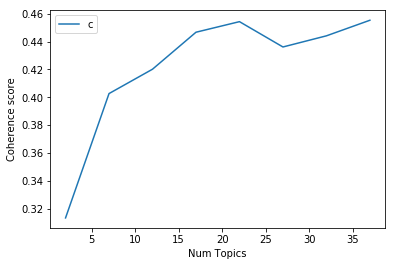

In [56]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

There looks to be a maximum at 22 topics but at 15 the score flattens out so that would be a good choice too (we were looking at models with $2 + 5k\leq 40$ topics). 

Another good tool to evaluate the quality of the model is to visualize the topics using pyLDAvis.

In [14]:
pyLDAvis.enable_notebook()
vis_topics = pyLDAvis.gensim.prepare(lda, d2b_corpus, dictionary) 
vis_topics

D:\anaconda\envs\data4good\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.025785  0.028993       1        1  11.675025
5     -0.088736 -0.042990       2        1  11.448876
3     -0.048462 -0.028754       3        1  11.336349
8     -0.026144  0.055689       4        1  10.512081
2     -0.014920  0.002133       5        1  10.067335
7      0.018570  0.036923       6        1   9.835085
0     -0.033429 -0.096152       7        1   9.288779
6     -0.037536  0.095364       8        1   9.261988
9      0.187594  0.001956       9        1   8.702563
4      0.068848 -0.053163      10        1   7.871915, topic_info=     Category         Freq                         Term        Total  loglift  \
58    Default  1113.000000                         gmbh  1113.000000  30.0000   
2228  Default   644.000000                  gebäudegrün   644.000000  29.0000   
1419  Default   663.000000                            l   663.000000  28.0000   
1498  Default   749.000000                        green   749.000000  27.0000   
836   Default   469.000000                       quelle   469.000000  26.0000   
207   Default   386.000000                          tel   386.000000  25.0000   
1288  Default   223.000000                           co   223.000000  24.0000   
1291  Default   201.000000                           kg   201.000000  23.0000   
0     Default   669.000000                       berlin   669.000000  22.0000   
1202  Default   362.000000            bauwerksbegrünung   362.000000  21.0000   
1239  Default   291.000000                         roof   291.000000  20.0000   
193   Default   388.000000                            e   388.000000  19.0000   
2612  Default    92.000000  fassadenbegrünungssymposium    92.000000  18.0000   
594   Default   185.000000                           de   185.000000  17.0000   
1515  Default   223.000000                        roofs   223.000000  16.0000   
2461  Default   122.000000                       pfoser   122.000000  15.0000   
2513  Default    97.000000            gründachsymposium    97.000000  14.0000   
1203  Default   217.000000              fachvereinigung   217.000000  13.0000   
1522  Default   165.000000                     greening   165.000000  12.0000   
1219  Default   373.000000                          fbb   373.000000  11.0000   
506   Default   301.000000                        urban   301.000000  10.0000   
854   Default   146.000000                       design   146.000000   9.0000   
202   Default   190.000000                          fax   190.000000   8.0000   
8     Default   913.000000                dachbegrünung   913.000000   7.0000   
81    Default   218.000000                           cm   218.000000   6.0000   
187   Default   357.000000                         grün   357.000000   5.0000   
1749  Default   164.000000                           ag   164.000000   4.0000   
1501  Default    92.000000                    buildings    92.000000   3.0000   
850   Default   185.000000                         info   185.000000   2.0000   
1529  Default    68.000000                  development    68.000000   1.0000   
...       ...          ...                          ...          ...      ...   
193   Topic10   127.887276                            e   388.261871   1.4313   
1203  Topic10    78.289734              fachvereinigung   217.906296   1.5182   
1120  Topic10    41.212769                       garten    96.932816   1.6866   
58    Topic10   240.635330                         gmbh  1113.096558   1.0103   
1202  Topic10   101.552849            bauwerksbegrünung   362.596527   1.2692   
63    Topic10    60.777397                      verband   188.399414   1.4105   
249   Topic10    54.183918                       verlag   159.545670   1.4619   
1288  Topic10    63.225964                           co   223.848999   1.2776   
2547  Topic10    31.503180                      vertiko    77.005981 



Further analysis might include:
<ul><li> finding the dominant topic for each sentence/document </li>
    <li> finding the most representative document for each topics </li>
    <li> look at the topic distribution in the documents </li>
    </ul>